# 07. 生成モデル

本章では生成モデルの代表例であるオートエンコーダーを実装する。

datasetはMNISTで、0～9の手書き数字の画像がラベルと一緒に格納されている。これを学習用と検証用に分けて利用する。

所要時間：<font color="Red">3~5時間</font>

## ライブラリのインポート

In [1]:
%matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import scipy
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

rng = np.random.RandomState(1234)
random_state = 42

## データセットの用意

データセットはpytorchに含まれているため、簡単に呼び出してローカルに保存できる。

さらに前処理はComposeでひとまとめにする。「ToTensor」はデータセットをテンソル化する関数，「Lambda」は「view(-1)」を表す自作関数で，データセットを一次元配列化する役割を担っている。

In [2]:
# 複数のTransform（データの前処理）を連続して行うインスタンス"transform"を用意
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))])

batch_size = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 15

# バッチごとに取り出した学習データを準備
dataloader_train = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

# バッチごとに取り出したテストデータを準備
dataloader_test = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

データを確認して順番に5つ表示してみよう。

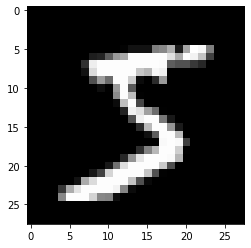

label:  tensor(5)


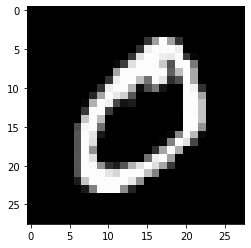

label:  tensor(0)


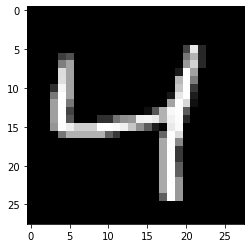

label:  tensor(4)


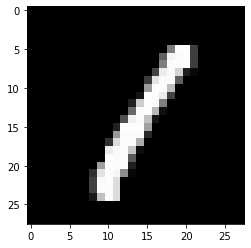

label:  tensor(1)


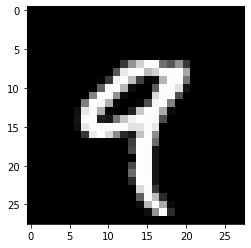

label:  tensor(9)


In [3]:
# データの確認
batch_train = next(iter(dataloader_train))

# データを5つ表示
for i in range(5):
    plt.gray()
    plt.imshow(batch_train[0][i].reshape((28,28)))
    plt.show()
    print("label: ", batch_train[1][i])

## AEによるMNISTの画像生成（PyTorch）

オートエンコーダーは、エンコーダーで元の画像を低次元の特徴量に圧縮して、デコーダーで低次元の特徴量から元の画像を復元させるようなネットワークである。



#### AE(Auto Encoder)について

AEとはエンコーダーとデコーダーの2つのニューラルネットワークを結合したモデルで、データの圧縮や異常検知に使われる。

#### AEの基本的な構造

Encoder-Decoderモデルでは、<font color="Green">Encoder</font>により潜在変数に落とし込み（情報を圧縮し）、<font color="Blue">Decoder</font>により潜在変数からデータ生成を行います。

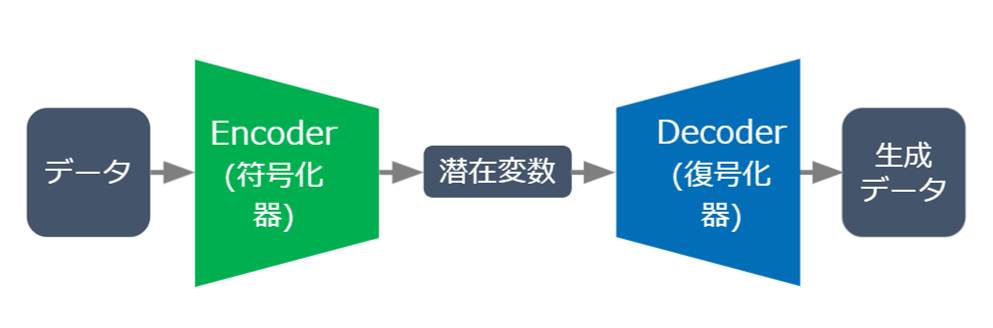

---
### <font color="Red">ワーク</font>
#### 全結合層を実装しよう

以下のサンプルを全結合層に入力します

In [4]:
import torch
import torch.nn as nn

a = torch.rand(1, 5) # [バッチサイズ, 入力データの次元数]
a

tensor([[0.9825, 0.8219, 0.5956, 0.9214, 0.8107]])

①nn.Linearを使って、全結合層を定義しよう<br>
※入力の次元数：5, 出力次元数：２  とする 

In [6]:
fc = ####
fc

②全結合層にサンプルを入力して結果を確認しよう<br>
※２つの数字が出力されていれば正解！

In [8]:
output = ####
output

---
今回実装するモデルの構造は
```
Encoder: 512次元→64次元→32次元→10次元
Decoder: 10次元→32次元→64次元→512次元
```
とします。



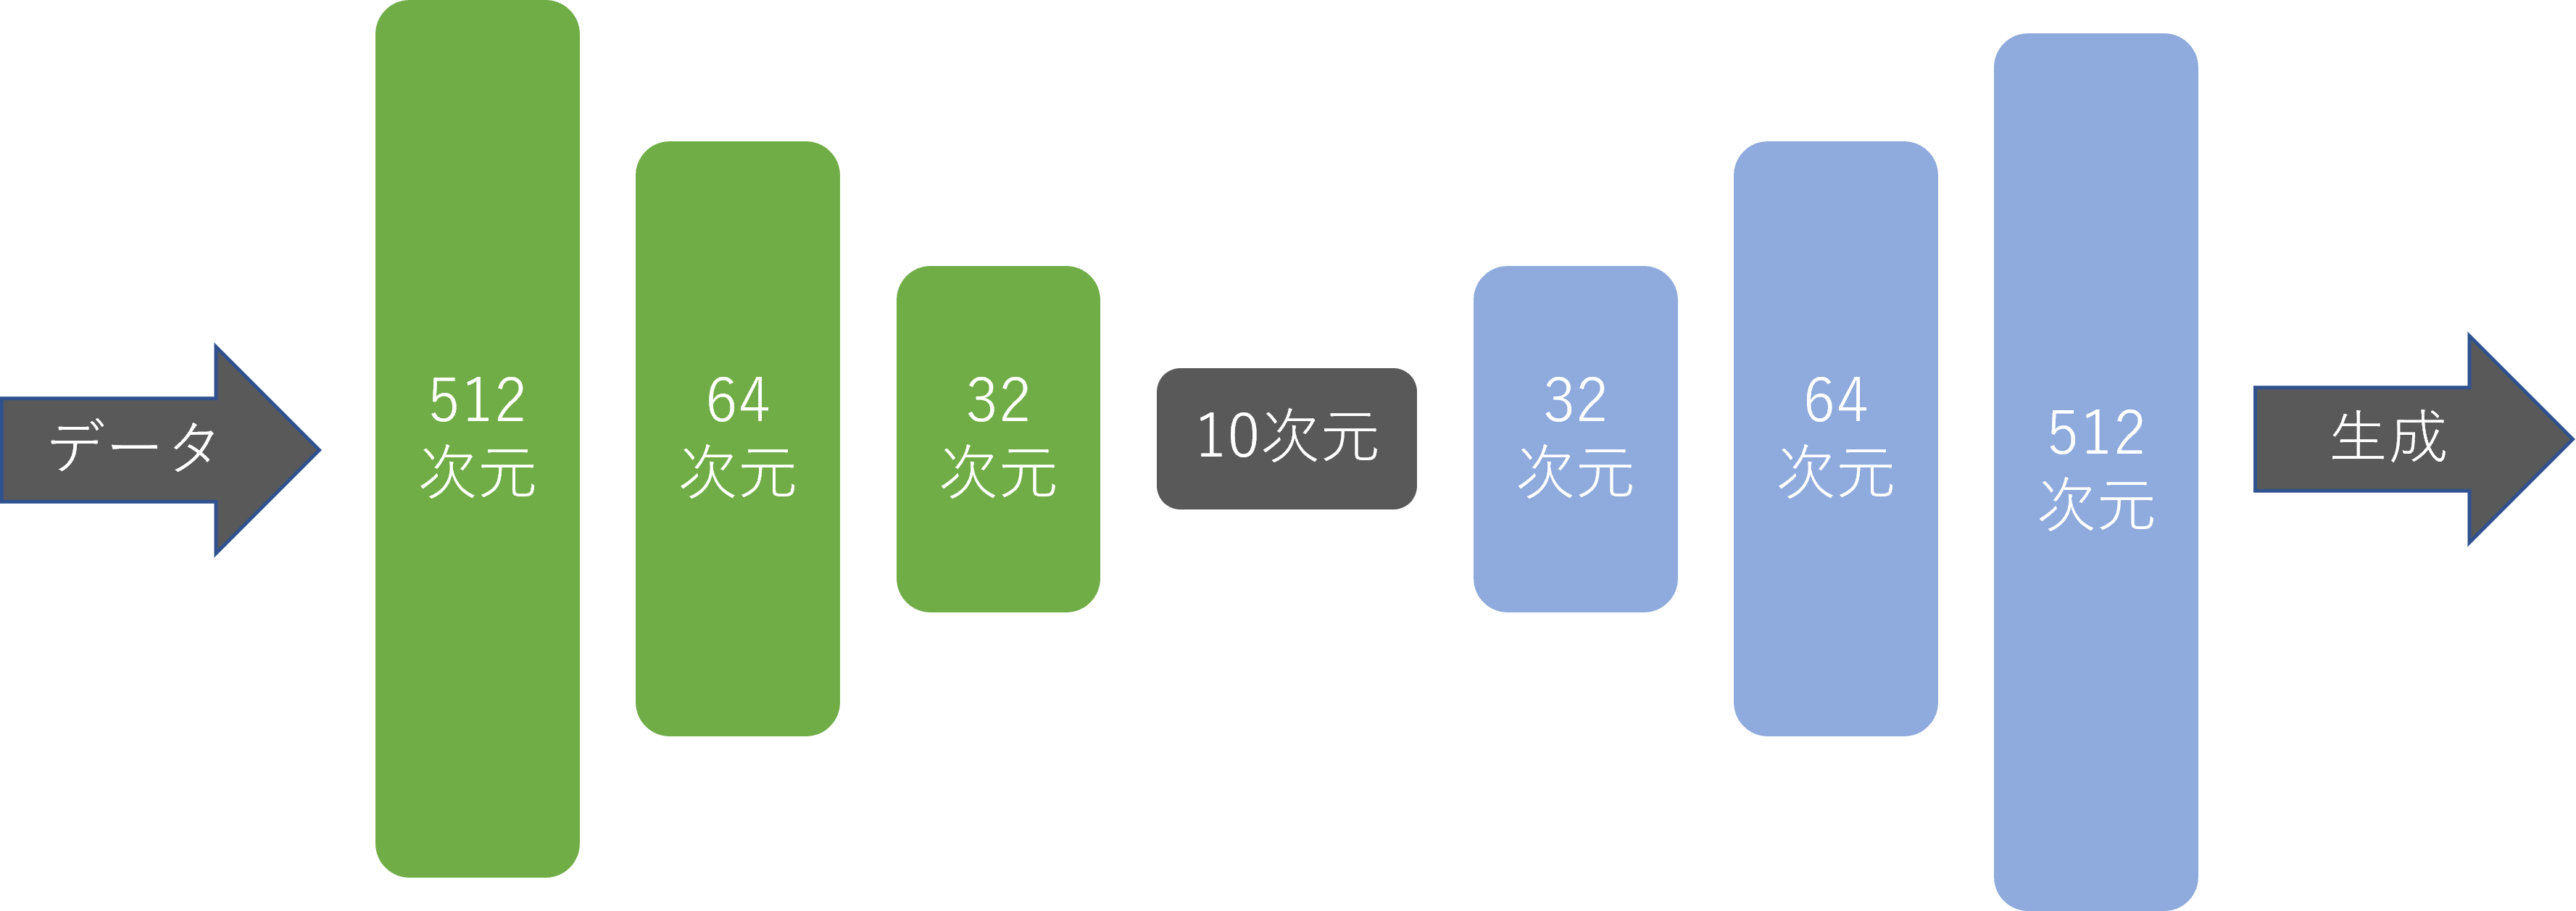

* <font color="Red">問1-1. 【イニシャライザ】第1層ではデータを512次元に圧縮する。データセットの次元を求めて、nn.Linearの引数に入力しよう。</font><br>
* <font color="Red">問1-2. 【イニシャライザ】最終層では512次元のデータを元の次元に復元する。データセットの次元を求めて、nn.Linearの引数に入力しよう。</font><br>
* <font color="Red">問1-3. 【encoder関数】エンコーダーでは活性化関数ReLUを介してデータxを各層に読み込ませていく。**self.dense_enc〇**(〇は1～4の数字)を引数として、encoderの層別構造を記述しよう。なお、encoderの4層目は出力になるため活性化関数は不要である。</font><br>        
* <font color="Red">問1-4. 【decoder関数】問1-3と同様の手順で、decoderの層別構造を記述しよう。(デコーダーでは最後にsigmoid関数に通します。）</font><br>

#### AEの損失関数

`reconstruction loss`は入力画像をどれだけ正確に復元できたかを表す損失値です。

交差エントロピー誤差を適応します。

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$

```
【関数の説明】
  nn.Linear(input_dim, output_dim): 全結合層を実装できる関数です。入力データの次元と出力データの次元をそれぞれ`input_dim`, `output_dim`で指定します。
  F.relu(input): テンソルinputに対するReLU関数の出力を返します。
  torch.sigmoid(input): テンソルinputに対するシグモイド関数の出力を返します。
  torch.mean(input, dim): テンソルinputの次元dimに対して平均値を返します。
  torch.sum(input, dim): テンソルinputの次元dimに対して合計値を返します。
```

* <font color="Red">問1-5. 【loss関数】入力 x と出力 y から、損失関数reconstraction lossの値を算出しよう。

In [9]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.dense_enc1 = ### 問1-1 ###
        self.dense_enc2 = nn.Linear(512, 64)
        self.dense_enc3 = nn.Linear(64, 32)
        self.dense_enc4 = nn.Linear(32, 10)
        self.dense_dec1 = nn.Linear(10, 32)
        self.dense_dec2 = nn.Linear(32, 64)
        self.dense_dec3 = nn.Linear(64, 512)
        self.dense_dec4 = ### 問1-2 ###

    def _encoder(self, x): 
        ### 問1-3 ###
        x = self.dense_enc4(x)
        return x

    def _decoder(self, x):
        ### 問1-4 ###
        x = torch.sigmoid(self.dense_dec4(x))
        return x

    def forward(self, x):
        x = self._encoder(x)
        x = self._decoder(x)
        return x

    def loss(self, x):
        y = self._encoder(x)
        y = self._decoder(y)

        # reconstruction lossの計算
        reconstruction = ### 問1-5 ###

        return reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

### <font color="Red">ガイド</font>

(問1-1)  
第1層は入力データを512次元に圧縮する全結合層となります。   
全結合層は Pytorch の提供する関数 `nn.Linear()` を利用することで実装することができます。  
【関数の説明】より、関数 `nn.Linear()` は以下の引数を持つため、それぞれに与えるべき値を考えます。
```
nn.Linear(input_dim, output_dim):
 - input_dim: 入力データの次元
 - output_dim: 出力データの次元
```

1. 入力データの次元 `input_dim` について  
第1層はモデルの最初の層であるため、AEに与えるデータが入力となります。  
今回使用するデータは MNIST であるため、入力データの次元 `input_dim` はMNIST のデータ1つあたりのサイズとなることがわかります。  
「データセットの用意」より、MNIST のデータは変数`dataloader_train`、`dataloader_test` に格納されていることがわかりますが、これらはイテレータであり、スライスによる指定や `.shape()`による形状確認ができません。  
MNIST 画像を5枚表示するコードセル1行目はイテレータを list 型に変換するコードです。
```
batch_train = next(iter(dataloader_train))
```
すなわち、`batch_train` からスライスや `.shape()` 等を利用した MNIST のサイズ確認が可能となっています。

2. 出力データの次元 `output_dim` について   
`output_dim`　には出力として得たい、圧縮後の次元数を渡します。

<br>

(問1-2)  
AEのモデル構造より、最終層は512次元のデータを元の次元に復元する全結合層となります。   
使用する関数 `nn.Linear()` については問1-1の通りです。  

1. 入力データの次元 `input_dim` について  
前の層の出力を入力データとして受け取るため、前の層の出力次元数を確認することで `input_dim` の値を決定することができます。  

2. 出力データの次元 `output_dim` について  
この層はデータの元々の次元を復元する層であるため、MNIST のデータ1つあたりのサイズを `output_dim` に渡すことがわかります。

<br>

(問1-3)  
encoder は、AEの構造のうち情報の圧縮を行う部分を指します。  

問題文の「活性化関数ReLUを介してデータxを各層に読み込ませる」を参考に実装を行います。  
これは入力 `x` を層に渡し、その出力をさらに次の層へ渡すことを繰り返す処理となっています。

1. 入力 `x` を encoder の1層目に渡す  
問1-1のコードより、encoder の1層目は `self.dense_enc1` としてインスタンス化されていることがわかります。  
つまり、`self.dense_enc1` に入力を渡すことで層に対し入力を与えることが可能となっています。

2. 層から得られる出力に対し、活性化関数ReLUを適用    
活性化関数ReLUは Pytorch の提供する関数 `F.relu()` を利用することで実装することができます。  

以上の手順によって入力 `x` を用意した層に与えていくことでencoderの層別構造を記述することができます。    
このとき、encoderの4層目は出力になるため活性化関数が不要となっています。

<br>

(問1-4)  
decoder は、AEの構造のうち情報の復元を行う部分を指します。 

層別構造の記述は問1-3の encoder の記述と同様の手順によって行うことができます。

問1-5の交差エントロピー誤差の計算に用いる出力 $y$ の値を 0〜1 の間に収めるために、decoder の最終層では sigmoid 関数が利用されています。

<br>

(問1-5)  
以下の式を実装し、損失を計算します。  
この損失は「入力画像をどれだけ正確に復元できたか」を表す指標として利用されます。

$$
\text{reconstruction loss} = \frac{1}{N}\sum^{N}_{i=1} \sum^{C}_{c=1}\{{-x_{ic}\log{y_{ic}}-(1-x_{ic})\log(1-y_{ic})}\}
$$

このとき各変数の意味については以下の通りです。


*   $N$ : バッチ数
*   $C$ : 各ピクセルに格納されている値
*   $x$ : 入力画像
*   $y$ : decoderからの出力画像

上記の式ではまず各ピクセルごとに総和を求め、その後得られた損失のバッチ数における平均を取ります。 

ここでdecoderからの出力画像 $y$ はAEによって復元された画像であり、その形状は [N, C] となっています。

このとき総和は各ピクセルに対して求めるため、対象とする軸に沿った計算を行う必要があることに留意してください。  
`torch.sum()` を利用して総和計算を行う場合、軸の指定は引数 `dim` によって行うことができます。

また、対数の計算では0以下を取った場合正常な演算が行われません。   
これを防ぐため今回の設問ではコードセル37行目以降に関数 `torch_log()` が定義されているため、log計算の際には利用していきましょう。



---




#### torch_log() について

問1-5のガイドにもある通り、対数の計算では0以下を取った場合正常な演算ができなくなり、Not a Number ( `NaN` ) や inf（∞）が返されます。  
これを防ぐために用意されている関数 `torch_log()` の挙動を確認します。

`torch_log()` の定義については以下の通りです

In [10]:
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

まず、PyTorch から提供されている関数 `torch.log()` が0を渡された場合の出力を確認します。

In [11]:
# テスト用に0で初期化されたテンソルを用意
test = torch.zeros(2, 3)
print(test)

tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [12]:
# torch.log()： torchで提供されるlog計算関数
torch.log(test)

tensor([[-inf, -inf, -inf],
        [-inf, -inf, -inf]])

次に、今回定義した `torch_log()` が0を渡された場合の出力を確認します。

In [13]:
# torch_log()： NaN回避を組み込んだ独自のlog計算関数
torch_log(test)

tensor([[-23.0259, -23.0259, -23.0259],
        [-23.0259, -23.0259, -23.0259]])

以上のように、`torch_log()` では log 計算の際に0を渡した場合も数値が出力されることがわかります。



---



### 学習と評価

学習を進めていくと、次第にtest用データに対する損失がreconstraction_lossに近づいていく様子が分かる。

In [14]:
AE_model = AE().to(device)
optimizer = optim.Adam(AE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    reconstruction_losses = []
    AE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        AE_model.zero_grad()
        reconstruction_loss = AE_model.loss(x)
        
        loss = reconstruction_loss
        
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    AE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        reconstruction_loss = AE_model.loss(x)

        loss = reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:182.251907, (182.251907), Test Lower Bound:139.570816
EPOCH:2, Train Lower Bound:123.560493, (123.560493), Test Lower Bound:119.148758
EPOCH:3, Train Lower Bound:111.411575, (111.411575), Test Lower Bound:110.831642
EPOCH:4, Train Lower Bound:104.521820, (104.521820), Test Lower Bound:103.218567
EPOCH:5, Train Lower Bound:99.772499, (99.772499), Test Lower Bound:98.804543
EPOCH:6, Train Lower Bound:95.999947, (95.999947), Test Lower Bound:95.833588
EPOCH:7, Train Lower Bound:93.220505, (93.220505), Test Lower Bound:92.861710
EPOCH:8, Train Lower Bound:90.545639, (90.545639), Test Lower Bound:91.403183
EPOCH:9, Train Lower Bound:88.757133, (88.757133), Test Lower Bound:89.817345
EPOCH:10, Train Lower Bound:87.452751, (87.452751), Test Lower Bound:88.944901
EPOCH:11, Train Lower Bound:86.449127, (86.449127), Test Lower Bound:88.469131
EPOCH:12, Train Lower Bound:85.626831, (85.626831), Test Lower Bound:87.593399
EPOCH:13, Train Lower Bound:84.914009, (84.914009

### 元画像と復元画像の比較

テスト用データの画像を入力として、AEで再構成した画像と比較してみよう。

まずはオリジナルのテスト用データの画像を表示する。

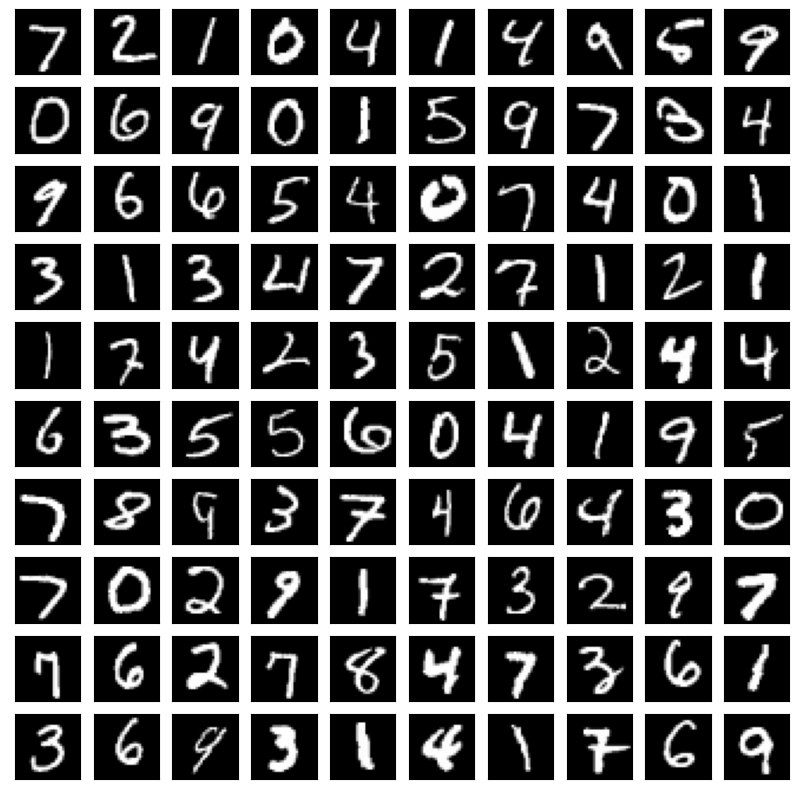

In [15]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、AEで再構成した画像を表示する。

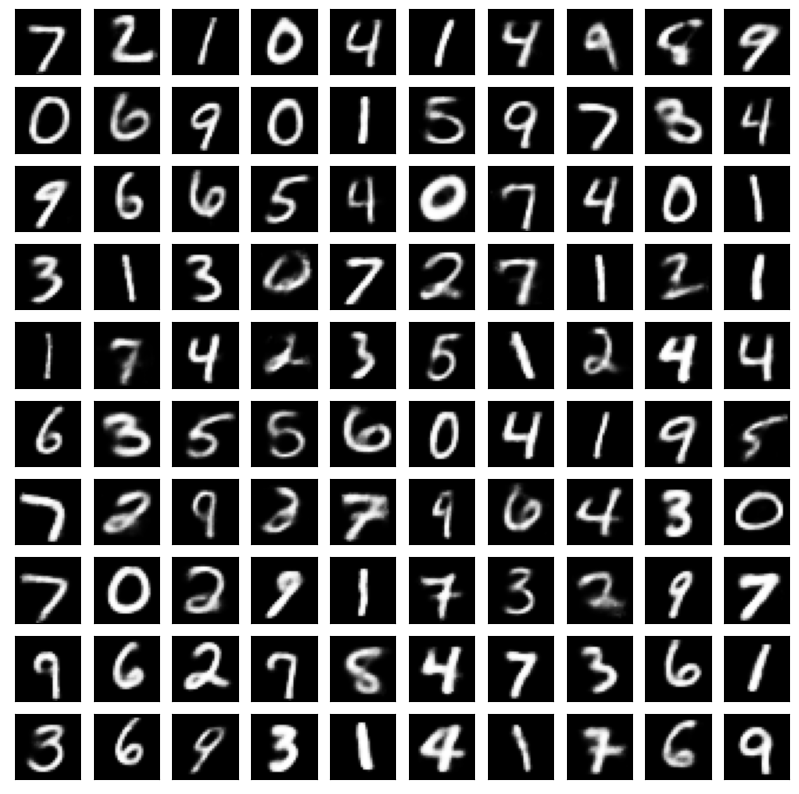

In [16]:
# AEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
AE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y = AE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## VAEによるMNISTの画像生成（PyTorch） 
#### VAEとは

エンコーダの目的はデータ分布を生成することです。

AEはもともと存在するデータを忠実に再現しようとします。しかし、忠実に再現しようとした結果、「遊び」がなく、連続性の高いデータ分布を生成することが出来ません。

そこでVAE(Variational Autoencoder)では、入力データを圧縮して得られる潜在変数を確率変数として表します。さらに潜在変数をガウス分布からサンプリングする制約を設けることでデータの潜在空間上での分布に連続性を持たせることが出来ます。

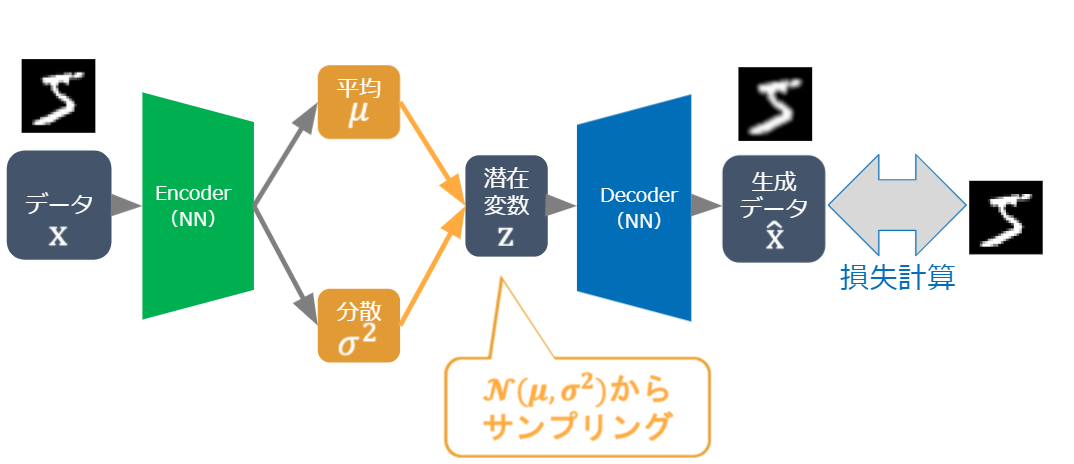

今回実装するモデルの構造は以下の通りです。

```
Encoder: 200次元→200次元→2次元
Decoder: 2次元→200次元→200次元
```


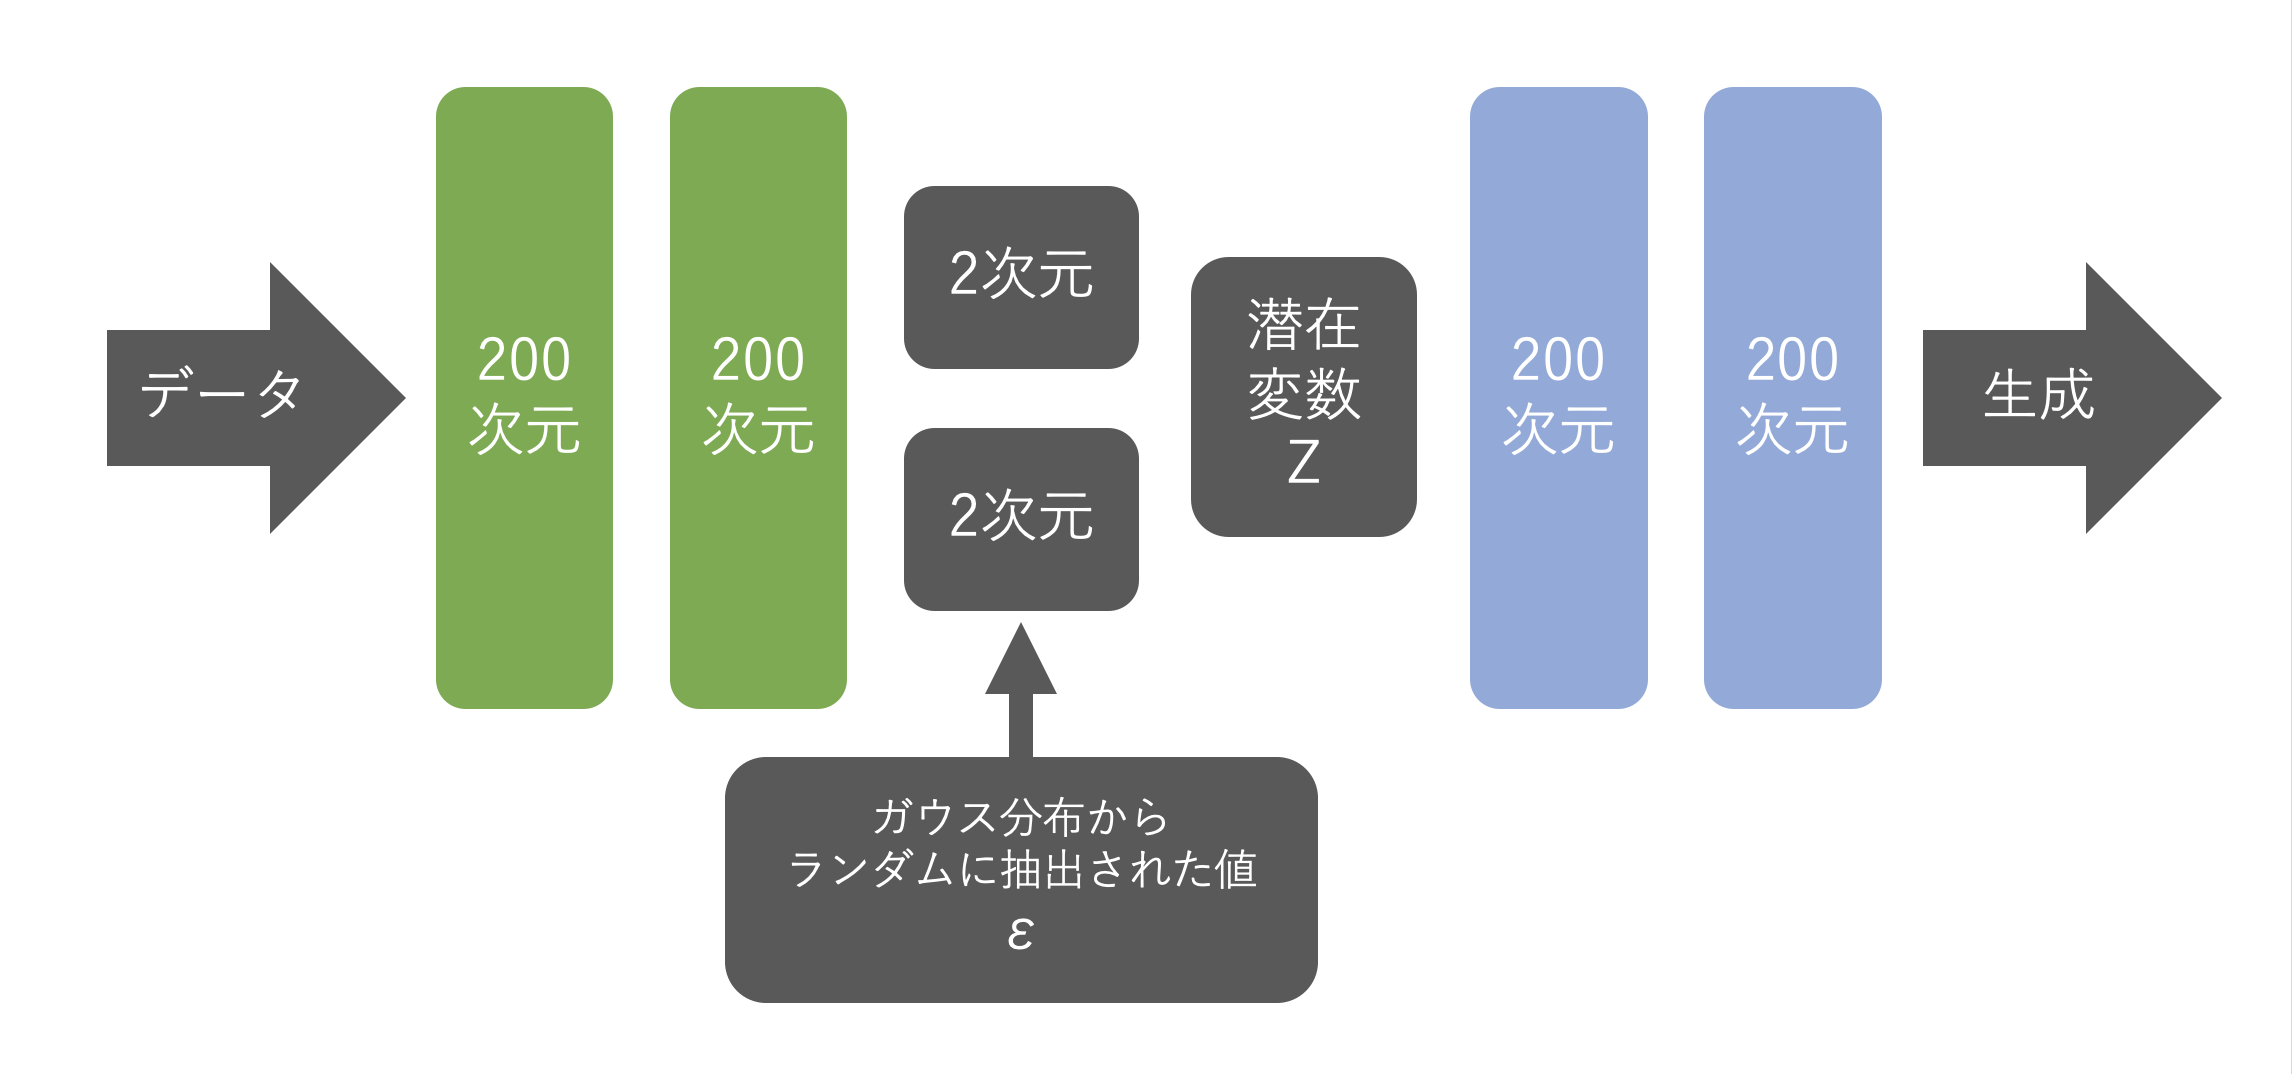

#### VAEのアルゴリズム



1. <font color='Green'>Encoder</font>により、データから$x$から潜在変数$z$の分布の平均$\mu$と分散$\sigma^2$を出力する。<br>
2. 出力された平均$\mu$と分散$\sigma^2$のガウス分布に従う潜在変数$z$をサンプリングする。<br>
3. <font color='Blue'>Decoder</font>により、潜在変数$z$から新たなデータ$\hat{x}$を生成する。<br>
4. 以下の損失関数により損失計算

$$
\rm{reconstruction~loss} = \frac{1}{N}\sum^N\sum^C\{{-x\log{y}-(1-x)\log(1-y)}\}
$$
$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$
$$
\rm{loss} = \rm{reconstruction~loss} + \rm{KL}
$$

* <font color="Red">問2-1,2-2. 【encoder関数】平均，分散の算出式を記述</font><br>
* <font color="Red">問2-3. 【sampling関数】ガウス分布を算出する関数を完成させるてください。</font><br>
【ヒント】
ガウス分布からランダムに抽出された値を$\epsilon$とすると、ガウス分布に従う潜在変数$z$は以下のように算出されます。
$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


#### VAEの損失関数

KLダイバージェンスを使った損失は以下のように算出されます。

$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$

* <font color="Red">問2-4. 【loss関数】KL_lossの算出を記述してください。</font><br>

In [18]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x):
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = ### 問2-1 ###
        var = ### 問2-2 ###
        return mean, var

    def _sample_z(self, mean, var):
        epsilon = torch.randn(mean.shape) 
        return ### 問2-3 ###

    def _decoder(self, z):
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        x = torch.sigmoid(self.dense_dec3(x))
        return x

    def forward(self, x):
        mean, var = self._encoder(x)
        z = self._sample_z(mean, var)
        x = self._decoder(z)
        return x, z

    def loss(self, x):
        mean, var = self._encoder(x)
        # KL lossの計算
        KL = -0.5 * ### 問2-4 ###

        z = self._sample_z(mean, var)
        y = self._decoder(z)

        # reconstruction lossの計算
        reconstruction = torch.mean(torch.sum(-x * self.torch_log(y) - (1 - x) * self.torch_log(1 - y), dim=1))

        return KL, reconstruction 
    
    # torch.log(0)によるnanを防ぐ
    def torch_log(self, x):
        return torch.log(torch.clamp(x, min=1e-10))

### <font color="Red">ガイド</font>

(問2-1, 2-2)  
コンストラクタ `__init__()` を見ると、Encoder に関する層として名称に `enc` を持つ変数の初期化がされていることがわかります。  
現在2層目まで入力 `x` が渡されているため、これを平均 $\mu$ や分散 $\sigma^2$ を算出する層に渡し、その結果をそれぞれ変数 `mean` ・ `ver` に格納します。

このとき、分散 $\sigma^{2}$ は負の値を取ることができないことに留意してください。  
これを防ぐための手法として、入力された値を 0.0〜∞ の正の値に変換するsoftplus関数の利用などが挙げられます。  
PyTorch の場合、softplus関数は `torch.nn.functional.softplus()` によって利用することが可能です。  
今回はインポートの際に以下のようにして省略名 `F` が与えられているため、 `F.softplus()` となります。

```
import torch.nn.functional as F
```
他にも、出力を分散の対数 $\log \sigma^{2}$ として計算する方法などが存在します。

<br>

(問2-3)  
ヒントの通り、ガウス分布からランダムに抽出された値を $\epsilon$ とする際、平均 $\mu$ と分散 $\sigma^2$ のガウス分布に従う潜在変数 $z$ は以下のガウス分布に従います。  

$$
\epsilon = \frac{z-\mu}{\sigma}~~~~~\Longrightarrow~~~~~z=\mu+\sigma\epsilon
$$


*   $z$ : ガウス分布に従う潜在変数
*   $\mu$ : 平均
*   $\sigma$ : 標準偏差
*   $\epsilon$ : ガウス分布からランダムに抽出された値



平均 $\mu$ と分散 $\sigma^2$ に関しては問2-1、 2-2で、$\epsilon$ はコードセル20行目の以下の記述によって算出されているため、これらを用いて上記の式を実装します。

```
epsilon = torch.randn(mean.shape) 
```


<br>

(問2-4) 
KLダイバージェンスを使った損失の式は以下の通りです。 

$$
\rm{KL} =  - \frac{1}{2N}\sum^N\sum^C{(1+log\sigma^2-\mu^2-\sigma^2)}
$$ 

上記の式は、まず各データごとの総和を求め、その後得られた各データの損失の平均を取ることを意味しています。  
$\sigma^2$ は分散 `ver` を示すことに注意してください。

また、log の計算に0を与えないようにする必要があります。  
今回の場合も48行目以降に、log の算出を行う対象が0になることを回避する関数が以下のように定義されているため、合わせて参照してください。
```
def torch_log(self, x):
    return torch.log(torch.clamp(x, min=1e-10))
```

### 学習と評価

In [19]:
z_dim = 2#10
VAE_model = VAE(z_dim).to(device)
optimizer = optim.Adam(VAE_model.parameters(), lr=0.001)
for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []
    VAE_model.train()
    for x, _ in dataloader_train:

        x = x.to(device)

        VAE_model.zero_grad()
        KL_loss, reconstruction_loss = VAE_model.loss(x)  # lossの各項の計算

        loss = KL_loss + reconstruction_loss  # 和を取ってlossとする

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_test = []
    VAE_model.eval()
    for x, t in dataloader_test:

        x = x.to(device)

        KL_loss, reconstruction_loss = VAE_model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_test.append(loss.cpu().detach().numpy())

    print('EPOCH:%d, Train Lower Bound:%lf, (%lf, %lf), Test Lower Bound:%lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_test)))

EPOCH:1, Train Lower Bound:189.617706, (3.748704, 185.869003), Test Lower Bound:173.445862
EPOCH:2, Train Lower Bound:165.031738, (4.966924, 160.064819), Test Lower Bound:162.806000
EPOCH:3, Train Lower Bound:158.663315, (5.364228, 153.299072), Test Lower Bound:158.611633
EPOCH:4, Train Lower Bound:154.908813, (5.623125, 149.285675), Test Lower Bound:155.244293
EPOCH:5, Train Lower Bound:152.134827, (5.811042, 146.323776), Test Lower Bound:154.274841
EPOCH:6, Train Lower Bound:150.279373, (5.908915, 144.370468), Test Lower Bound:152.237457
EPOCH:7, Train Lower Bound:148.966095, (6.001734, 142.964355), Test Lower Bound:150.756821
EPOCH:8, Train Lower Bound:147.628784, (6.090332, 141.538467), Test Lower Bound:148.852234
EPOCH:9, Train Lower Bound:146.760834, (6.152654, 140.608170), Test Lower Bound:148.386459
EPOCH:10, Train Lower Bound:145.964783, (6.216253, 139.748535), Test Lower Bound:148.455795
EPOCH:11, Train Lower Bound:145.320389, (6.268255, 139.052139), Test Lower Bound:147.0009

---
### <font color="Red">ワーク</font>
#### Reparametrization Trickを実装しよう！
潜在変数zの出力を確認してみよう



①ガウス分布から乱数を２つ生成しよう！（ヒント： torch.randn(形状)を使う）

In [21]:
import torch

epsilon = ###
epsilon

②平均と分散を用いて、潜在変数zを求めてみよう！($\mu$は平均、$\sigma$は標準偏差、$\epsilon$は①の乱数)

$$
z=\mu+\sigma\epsilon
$$

In [22]:
mean = torch.Tensor([-0.1, 0.1])
var = torch.Tensor([0.1, 0.1])

z = ###
z

---
### 元画像と復元画像の比較

テスト用データの画像を入力として、VAEで再構成した画像と比較してみよう。

まずはオリジナルのテスト用データの画像を表示する。

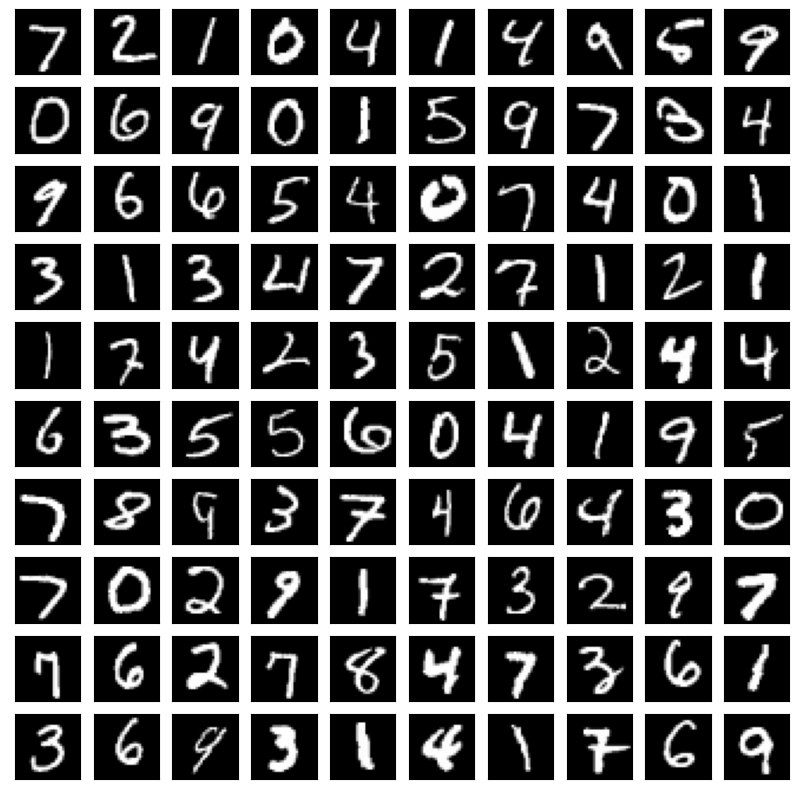

In [23]:
# オリジナルのMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

次に、VAEで再構成した画像を表示する。

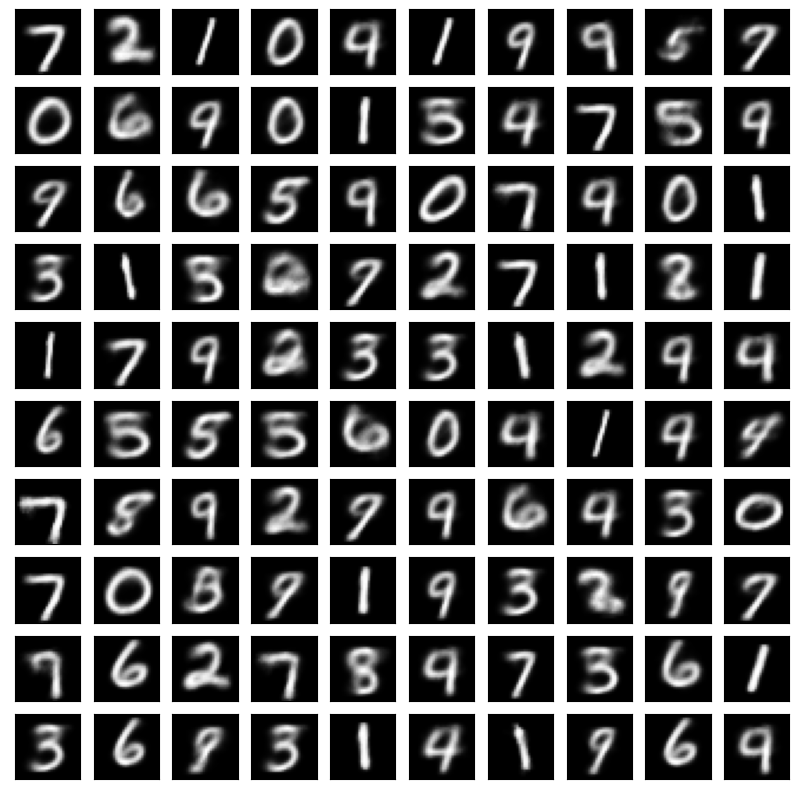

In [24]:
# VAEで再構成したMNISTイメージ
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    x, t = valid_dataset[i]
    x = x.to(device)
    x = x.unsqueeze(0)
    y, z = VAE_model(x)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

潜在変数からランダムサンプリングしてイメージを生成すると、以下のようになる。

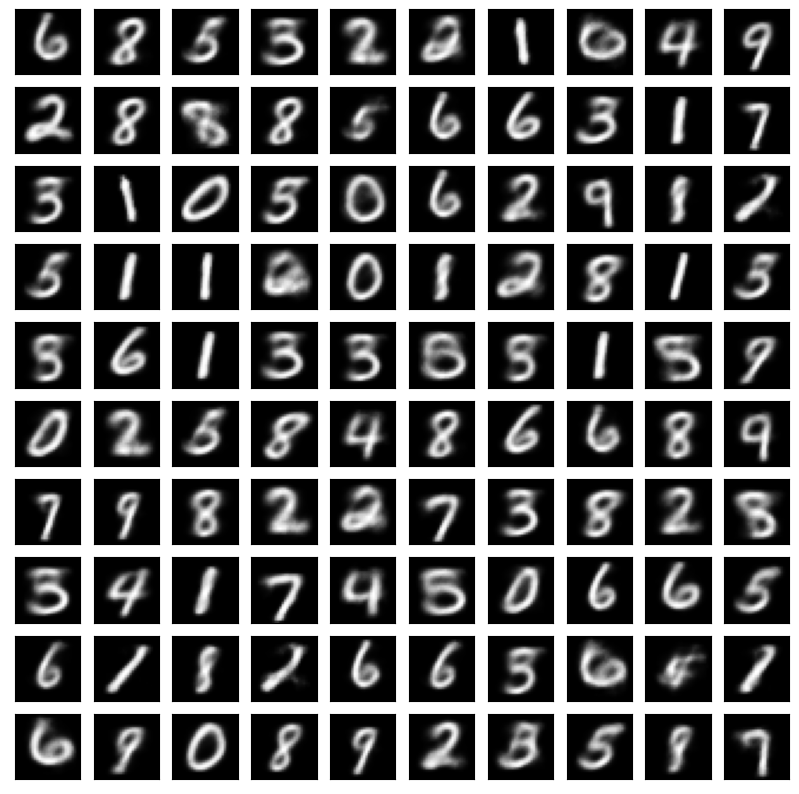

In [25]:
# 潜在変数からランダムサンプリング(潜在変数をランダムに決め, その潜在変数から生成されるMNISTイメージ)
fig = plt.figure(figsize=(10, 10))
VAE_model.eval()
for i in range(100):
    z = torch.randn([1, z_dim]).to(device)
    y = VAE_model._decoder(z)
    im = y.view(-1, 28, 28).permute(1, 2, 0).cpu().squeeze().detach().numpy()
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

最後に、潜在変数による連続的な変化を可視化してみよう。

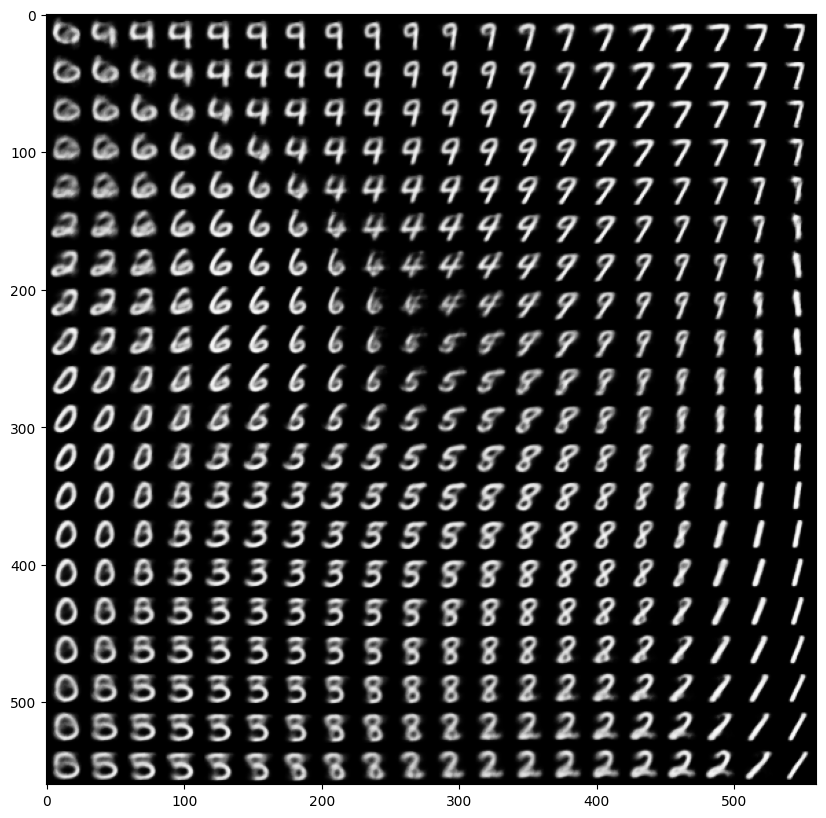

In [26]:
# 多様体の可視化
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 20
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        z_sample = torch.from_numpy(z_sample.astype(np.float32)).clone()
        x_decoded = VAE_model._decoder(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit.to('cpu').detach().numpy()

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()